In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np

In [22]:
def create_autoencoder(input_shape):
    # Encoder: Chuyển đổi đầu vào thành một vector nén
    input_layer = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(input_layer)
    x = layers.Dense(64, activation='relu')(x)
    encoded = layers.Dense(32, activation='relu')(x)

    # Decoder: Tái tạo lại đầu ra (logits)
    x = layers.Dense(64, activation='relu')(encoded)
    x = layers.Dense(128, activation='relu')(x)
    decoded = layers.Dense(input_shape[0], activation='softmax')(x)  # Tái tạo lại logits (10 lớp)

    # Tạo mô hình Autoencoder
    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return autoencoder


In [23]:
def create_inversion_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    # Thêm các lớp để chuyển logits thành hình ảnh gốc
    x = layers.Dense(128, activation='relu')(input_layer)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    
    # Tái tạo lại ảnh (28x28x1)
    reconstructed_input = layers.Dense(28 * 28, activation='sigmoid')(x)
    reconstructed_input = layers.Reshape((28, 28, 1))(reconstructed_input)  # Reshape thành ảnh (28, 28, 1)

    # Tạo mô hình nghịch đảo
    inversion_model = models.Model(input_layer, reconstructed_input)
    inversion_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return inversion_model


In [24]:
def train_with_ppf(cnn_model, autoencoder, inversion_model, x_train, y_train, epochs, batch_size):
    # Đầu ra của CNN (logits)
    logits = cnn_model(x_train)
    
    # Huấn luyện Autoencoder (Purifier) với logits
    autoencoder.fit(logits, logits, epochs=epochs, batch_size=batch_size)

    # Huấn luyện Inversion Model (tái tạo lại đầu vào từ logits)
    inverted_input = inversion_model(logits)
    inversion_model.fit(logits, x_train, epochs=epochs, batch_size=batch_size)  # Tái tạo lại đầu vào từ logits

    # Huấn luyện CNN (Mô hình mục tiêu)
    history = cnn_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return history, cnn_model, autoencoder, inversion_model


In [25]:
# Build the model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_simple_nn():
  model = Sequential([
      Flatten(input_shape=(28, 28, 1)),
      Dense(128, activation='relu'),
      Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [26]:
def create_cnn():
  model = Sequential([
      layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
      layers.MaxPooling2D(pool_size=2),
      layers.Conv2D(64, kernel_size=3, activation='relu'),
      layers.MaxPooling2D(pool_size=2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(10, activation='softmax') # Đây là logits mà chúng ta muốn purifier
  ])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [27]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add channel dimension
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [28]:
victim_epochs = 10
victim_batch_size = 128

## Simple_CNN

In [29]:
# Create Simple CNN model
simple_nn_model = create_simple_nn()
autoencoder = create_autoencoder((10,))  # Logits có dạng (batch_size, 10)
inversion_model = create_inversion_model((10,))

In [30]:
history_simple_nn_model, simple_nn_model, autoencoder, inversion_model = train_with_ppf(
    simple_nn_model, autoencoder, inversion_model, x_train, y_train, epochs = victim_epochs, batch_size = victim_batch_size)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5163 - loss: 2.2458
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9290 - loss: 2.2199
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9533 - loss: 2.2183
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9605 - loss: 2.2185
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9651 - loss: 2.2187
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9680 - loss: 2.2181
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9689 - loss: 2.2182
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9731 - loss: 2.2183
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9760 - loss: 2.2181
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9776 - loss: 2.2181
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7870 - loss: 0.0919
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step -

In [31]:
simple_nn_model.save("./PPF/victim_simple_cnn_model.keras")

In [32]:
loss, acc = simple_nn_model.evaluate(x_test, y_test)
print(f"Victim Model Accuracy On Test Set: {acc * 100.0:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9728 - loss: 0.0891
Victim Model Accuracy On Test Set: 97.66%


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


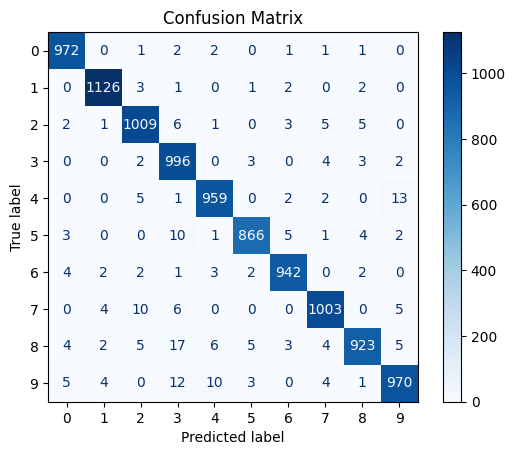

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class probabilities
y_pred_prob = simple_nn_model.predict(x_test)

# Convert predictions to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

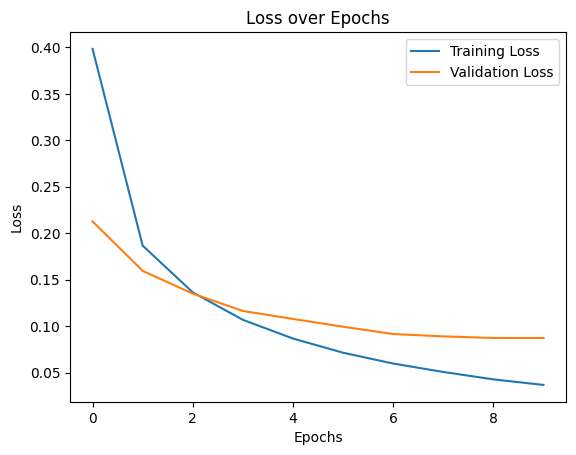

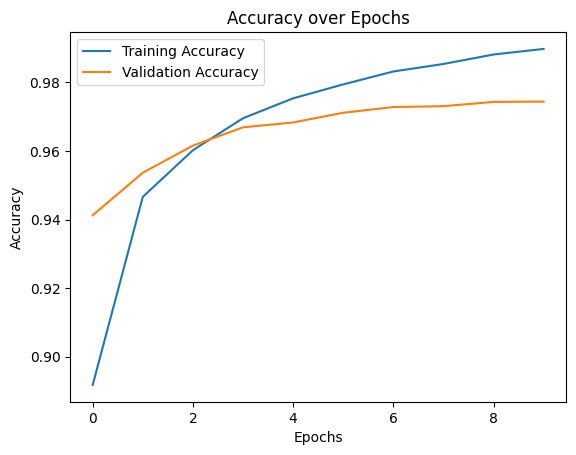

In [34]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history_simple_nn_model.history['loss'], label='Training Loss')
plt.plot(history_simple_nn_model.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_simple_nn_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_simple_nn_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Convolutional CNN

In [35]:
# Define victim model
c_nn_model = create_cnn()
autoencoder = create_autoencoder((10,))  # Logits có dạng (batch_size, 10)
inversion_model = create_inversion_model((10,))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# Train victim model
history_c_nn_model, c_nn_model, autoencoder, inversion_model = train_with_ppf(
    c_nn_model, autoencoder, inversion_model, x_train, y_train, epochs = victim_epochs, batch_size = victim_batch_size)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5473 - loss: 2.3003
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7239 - loss: 2.2998
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8227 - loss: 2.2997
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8388 - loss: 2.2996
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8561 - loss: 2.2996
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8697 - loss: 2.2995
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8694 - loss: 2.2995
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8766 - loss: 2.2995
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8848 - loss: 2.2995
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8857 - loss: 2.2995
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7874 - loss: 0.0933
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step -

In [37]:
c_nn_model.save("./PPF/victim_cnn_model.keras")

In [38]:
# Evaluate victim model
loss, acc = c_nn_model.evaluate(x_test, y_test)
print(f"Victim Model Accuracy On Test Set: {acc * 100.0:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9873 - loss: 0.0400
Victim Model Accuracy On Test Set: 99.07%


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


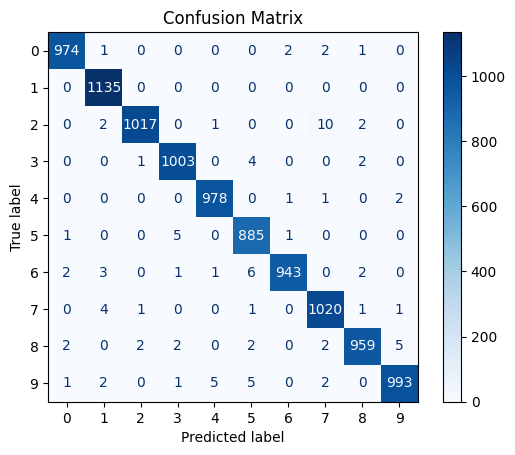

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class probabilities
y_pred_prob = c_nn_model.predict(x_test)

# Convert predictions to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

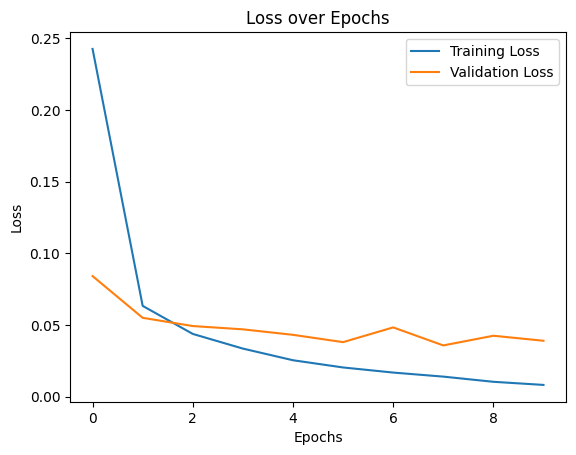

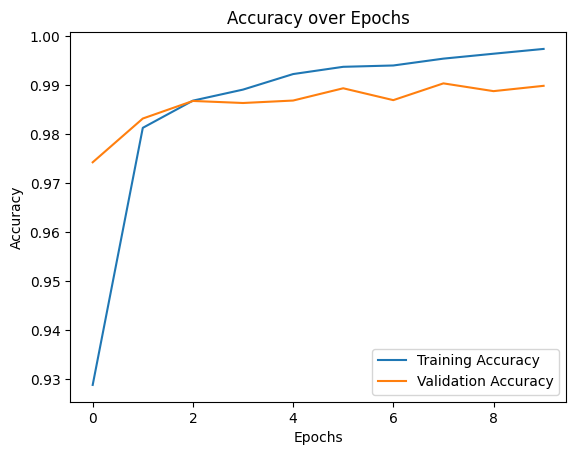

In [40]:
# Accessing and Displaying Training History
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history_c_nn_model.history['loss'], label='Training Loss')
plt.plot(history_c_nn_model.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_c_nn_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_c_nn_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()